## Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

tf.__version__ 

2024-03-26 19:29:25.326352: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 19:29:25.326473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 19:29:25.441845: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'2.15.0'

## Importing Dataset

In [2]:
path = "/kaggle/input/butterfly-images40-species/train/"



image_size = 224
batch_size = 128
channel_size = 3 #RGB

In [3]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1.0 / 255,
    
#     rotation_range=30,
    
#     horizontal_flip=True,
#     zoom_range=(0.1, 0.2),
    
#     brightness_range = (-0.2,0.2),
    
#     validation_split = 0.2
)

In [4]:
# Training dataset generator

train_generator = datagen.flow_from_directory(
    path,
    
    target_size=(image_size, image_size),
    batch_size=32,
    
    class_mode="categorical",
    
    shuffle=True,
    seed=42
)

Found 12594 images belonging to 100 classes.


In [5]:
# Validation dataset generator

validation_generator = datagen.flow_from_directory(
    '/kaggle/input/butterfly-images40-species/valid/',
    
    target_size=(image_size, image_size),
    batch_size=256,
    
    class_mode="categorical",
    
    shuffle=False,
    seed=42
)

Found 500 images belonging to 100 classes.


In [6]:
# images,labels = next(train_generator)

# for _ in range(5):
#     img, label = train_generator.next()
#     print(img.shape)   #  (1,256,256,3)
#     plt.imshow(img[0])
#     plt.show()

## Importing pretrained model for transfer learning

In [7]:
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape = (224,224,3),
    include_top = False,
    weights = 'imagenet',
    classes = 100,
    pooling = 'avg'
)

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
base_model.trainable = False

In [9]:
base_model.summary()

# Note that rescaling layer is pre-included

Model: "MobilenetV3large"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,996,352 (11.43 MB)

## Add class weights to mitigate class imbalance

In [10]:
from sklearn.utils.class_weight import compute_class_weight

classes = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(classes), y=classes)

## Finally train the model for transfer learning

In [11]:
num_classes = 100

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(224, 224, 3)))
model.add(tf.keras.layers.RandomFlip('horizontal'))
model.add(tf.keras.layers.RandomRotation(0.1))
model.add(tf.keras.layers.RandomZoom(0.1))
model.add(tf.keras.layers.RandomContrast(0.1))
model.add(base_model)
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))


model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['f1_score']
)


history = model.fit(
    train_generator,
    validation_data = validation_generator,

    class_weight = dict(enumerate(class_weights)),

    epochs=100,

    callbacks = [

        tf.keras.callbacks.ReduceLROnPlateau( # Reducing learning rate on plateau for better convergence
            monitor='val_loss',
            factor=0.5,
            patience=3
        ),

        tf.keras.callbacks.EarlyStopping( # Stopping at stagnation of validation loss decrease
            monitor='val_loss',
            patience=15,
            restore_best_weights = True
        )
    ]
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


394/394 ━━━━━━━━━━━━━━━━━━━━ 132s 303ms/step - f1_score: 0.5269 - loss: 2.4724 - val_f1_score: 0.8444 - val_loss: 0.6488 - learning_rate: 0.0100
Epoch 2/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 28s 69ms/step - f1_score: 0.7961 - loss: 1.0146 - val_f1_score: 0.8994 - val_loss: 0.4869 - learning_rate: 0.0100
Epoch 3/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - f1_score: 0.8229 - loss: 0.9435 - val_f1_score: 0.8761 - val_loss: 0.6643 - learning_rate: 0.0100
Epoch 4/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - f1_score: 0.8301 - loss: 0.9976 - val_f1_score: 0.9077 - val_loss: 0.6213 - learning_rate: 0.0100
Epoch 5/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - f1_score: 0.8466 - loss: 0.9898 - val_f1_score: 0.8922 - val_loss: 0.7397 - learning_rate: 0.0100
Epoch 6/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - f1_score: 0.8840 - loss: 0.7107 - val_f1_score: 0.9249 - val_loss: 0.4730 - learning_rate: 0.0050
Epoch 7/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - f1_score: 0.8977 - loss

## Plotting Loss and F1-Score Curves

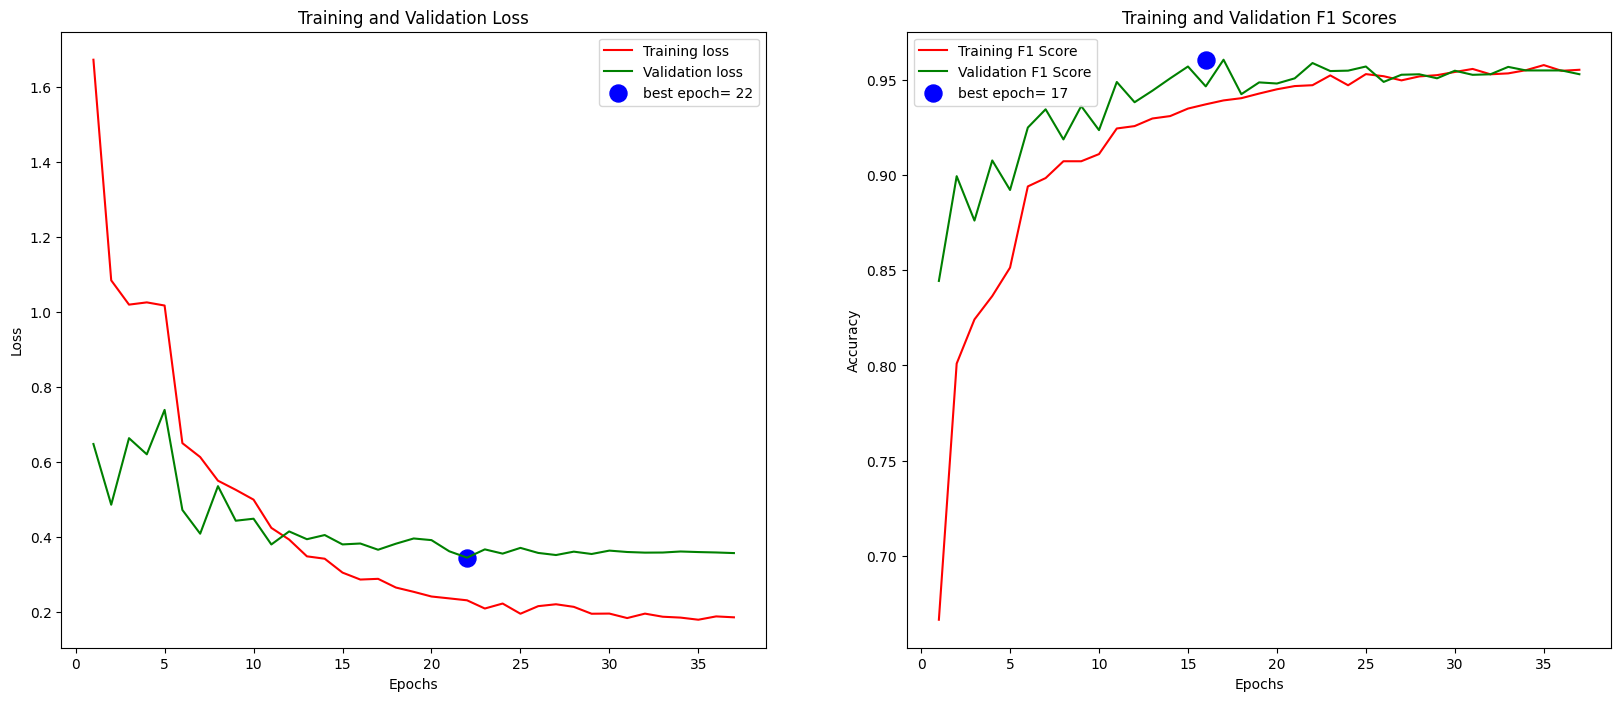

In [12]:
# Define needed variables
tr_acc = np.mean(history.history['f1_score'], axis=1)
tr_loss = history.history['loss']
val_acc = np.mean(history.history['val_f1_score'], axis=1)
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training F1 Score')
plt.plot(Epochs, val_acc, 'g', label= 'Validation F1 Score')
plt.scatter(index_acc , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation F1 Scores')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

## Saving The Model

In [15]:
model.save("trained_model_mobilenetV3.keras", overwrite=True)

## Plotting Confusion Matrix on Test Data

In [16]:
from sklearn.metrics import confusion_matrix

In [17]:
list(history.history.keys())

['f1_score', 'loss', 'val_f1_score', 'val_loss', 'learning_rate']

In [18]:
loaded_model = tf.keras.models.load_model('/kaggle/working/trained_model_mobilenetV3.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 346 variables whereas the saved optimizer has 6 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [19]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [20]:
test_generator = test_datagen.flow_from_directory(
    "/kaggle/input/butterfly-images40-species/test",
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    shuffle=False
)

Found 500 images belonging to 100 classes.


In [21]:
y_pred = model.predict(test_generator)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


In [22]:
(y_pred).shape

(500, 100)

In [23]:
y_pred_classes = np.argmax(
    np.reshape(y_pred, (y_pred.shape[0], num_classes)),
    axis=1
)

In [24]:
y_true = test_generator.classes

In [25]:
import sklearn

conf_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred_classes)

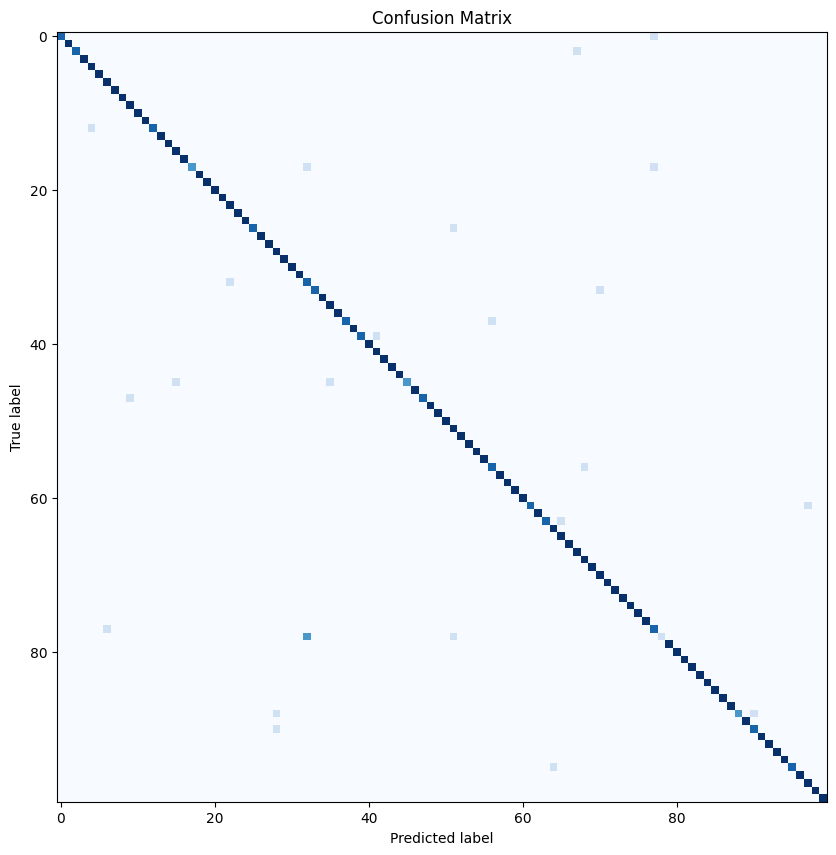

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## Test Run for Model

In [27]:
import matplotlib.image as mpimg

image = mpimg.imread('/kaggle/input/butterfly-images40-species/test/ADONIS/2.jpg')

In [28]:
from tensorflow.keras.preprocessing.image import img_to_array

# Preprocess the image
image = img_to_array(image)


image = np.reshape(image, (224, 224, 3))
image = np.expand_dims(image, axis=0)

In [29]:
prediction = loaded_model.predict(image)

W0000 00:00:1711482560.635515      25 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16274030592 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [30]:
# Get the class with the highest probability
class_index = prediction.argmax()

# Print the class index
print('Class index:', class_index)

Class index: 0


## THE END